# Group 26: Introduction to Social Data Science (ISDS), exam project 2023

## Can We Predict If a PGA Tour Player Won a Tournament and Their Earnings based on educational background?

## <a id='TOC'>Table of Contents</a>
<ol>
<li><a href='#section_1'>Data Collection: Accessing stats on the PGA Tour website</a></li>
<li><a href='#section_2'>Predicting winners with machine learning classification models</a></li>
<li><a href='#section_3'>Predicting earnings per tournament based on college background</a></li>
</ol>

## 1. <a id='section_1'>Data Collection: Accessing stats on the PGA Tour website </a>
<a href='#TOC'>Back to table of Contents</a>

### Importing Packages 

In [1]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

### Fetching data via API

In [2]:
def available_stats(category: int):
    """
    Retrieve available statistics within a specific category.
    
    Parameters:
        category (int): The index of the category for which to retrieve statistics.
    
    Returns:
        dict: Information about the statistics within the specified category.
    """
    X_API_KEY = "da2-gsrx5bibzbb4njvhl7t37wqyl4"
    payload = {
        "operationName": "StatDetails",
        "variables": {
            "tourCode": "R",
            "statId": 2,
            "year": 2023,
            "eventQuery": None
        },
        "query": (
            "query StatDetails($tourCode: TourCode!, $statId: String!, $year: Int, $eventQuery: StatDetailEventQuery) {\n"
            "  statDetails(\n"
            "    tourCode: $tourCode\n"
            "    statId: $statId\n"
            "    year: $year\n"
            "    eventQuery: $eventQuery\n"
            "  ) {\n"
            "    tourCode\n"
            "    year\n"
            "    displaySeason\n"
            "    statId\n"
            "    statType\n"
            "    tournamentPills {\n"
            "      tournamentId\n"
            "      displayName\n"
            "    }\n"
            "    yearPills {\n"
            "      year\n"
            "      displaySeason\n"
            "    }\n"
            "    statTitle\n"
            "    statDescription\n"
            "    tourAvg\n"
            "    lastProcessed\n"
            "    statHeaders\n"
            "    statCategories {\n"
            "      category\n"
            "      displayName\n"
            "      subCategories {\n"
            "        displayName\n"
            "        stats {\n"
            "          statId\n"
            "          statTitle\n"
            "        }\n"
            "      }\n"
            "    }\n"
            "    rows {\n"
            "      ... on StatDetailsPlayer {\n"
            "        __typename\n"
            "        playerId\n"
            "        playerName\n"
            "        country\n"
            "        countryFlag\n"
            "        rank\n"
            "        rankDiff\n"
            "        rankChangeTendency\n"
            "        stats {\n"
            "          statName\n"
            "          statValue\n"
            "          color\n"
            "        }\n"
            "      }\n"
            "      ... on StatDetailTourAvg {\n"
            "        __typename\n"
            "        displayName\n"
            "        value\n"
            "      }\n"
            "    }\n"
            "  }\n"
            "}"
        )
    }

    req = requests.post("https://orchestrator.pgatour.com/graphql", json=payload, headers={"x-api-key": X_API_KEY, 'name': 'Simon Knobelauch Hansen', 'email': 'Rfv228@alumni.ku.dk'})
    stats_in_category = req.json()["data"]["statDetails"]["statCategories"][category]
    return stats_in_category

In [3]:
# NOTEBOOK INFORMATION:
# -----------------------------------------------------------------------------
# The results computed from this notebook are used in the project
# "Can We Predict If a PGA Tour Player Won a Tournament in That Year and Their Earnings
# based on educational background?" the ourced from a run on 21st of August 2023.
# Due to ongoing golf events in the 2023 PGA Tour, the season 2023 dataset on which the results are based will change slightly of run later.
# To reproduce exact result, use the csv files provided in Github repo.  
# -----------------------------------------------------------------------------

As an example, we can retrieve the available stats in SCORING (category 5). There are 9 categories in total (0-8).

In [4]:
available_stats(category=5)

{'category': 'SCORING',
 'displayName': 'Scoring',
 'subCategories': [{'displayName': 'Strokes Gained - SG',
   'stats': [{'statId': '02675', 'statTitle': 'SG: Total'}]},
  {'displayName': 'Scoring Overall',
   'stats': [{'statId': '120', 'statTitle': 'Scoring Average'},
    {'statId': '108', 'statTitle': 'Scoring Average (Actual)'},
    {'statId': '116', 'statTitle': 'Scoring Average Before Cut'},
    {'statId': '02417', 'statTitle': 'Stroke Differential Field Average'},
    {'statId': '299', 'statTitle': 'Lowest Round'},
    {'statId': '152', 'statTitle': 'Rounds in the 60s'},
    {'statId': '153', 'statTitle': 'Sub-Par Rounds'}]},
  {'displayName': 'Under Par Scoring',
   'stats': [{'statId': '156', 'statTitle': 'Birdie Average'},
    {'statId': '107', 'statTitle': 'Total Birdies'},
    {'statId': '155', 'statTitle': 'Eagles (Holes per)'},
    {'statId': '106', 'statTitle': 'Total Eagles'},
    {'statId': '105', 'statTitle': 'Par Breakers'},
    {'statId': '160', 'statTitle': 'Bounc

We move on to building a function which can retrieve and merge the golf stats we want: 

In [5]:
def get_data(id_list: list):

    """
    Retrieve and merge statistics data based on a list of stat IDs.

    Parameters:
        id_list (list): List of stat IDs to retrieve data for.

    Returns:
        pd.DataFrame: Merged DataFrame containing statistics data.
    """
    
    X_API_KEY = "da2-gsrx5bibzbb4njvhl7t37wqyl4"
    YEAR = 2023 # Change this to the year you want to retrieve data for
    first_stat = True
    
    for stat_id in id_list:
        payload = {
            "operationName": "StatDetails",
            "variables": {
                "tourCode": "R",
                "statId": stat_id,
                "year": YEAR,
                "eventQuery": None
            },
         "query": "query StatDetails($tourCode: TourCode!, $statId: String!, $year: Int, $eventQuery: StatDetailEventQuery) {\n  statDetails(\n    tourCode: $tourCode\n    statId: $statId\n    year: $year\n    eventQuery: $eventQuery\n  ) {\n    tourCode\n    year\n    displaySeason\n    statId\n    statType\n    tournamentPills {\n      tournamentId\n      displayName\n    }\n    yearPills {\n      year\n      displaySeason\n    }\n    statTitle\n    statDescription\n    tourAvg\n    lastProcessed\n    statHeaders\n    statCategories {\n      category\n      displayName\n      subCategories {\n        displayName\n        stats {\n          statId\n          statTitle\n        }\n      }\n    }\n    rows {\n      ... on StatDetailsPlayer {\n        __typename\n        playerId\n        playerName\n        country\n        countryFlag\n        rank\n        rankDiff\n        rankChangeTendency\n        stats {\n          statName\n          statValue\n          color\n        }\n      }\n      ... on StatDetailTourAvg {\n        __typename\n        displayName\n        value\n      }\n    }\n  }\n}"  
      }
        page = requests.post("https://orchestrator.pgatour.com/graphql", json=payload, headers={"x-api-key": X_API_KEY ,'name':'Simon Knobelauch Hansen', 'email':'Rfv228@alumni.ku.dk'})
        page.raise_for_status()
        data = page.json()["data"]["statDetails"]["rows"]
        
        # For the first stat of the loop, we can not merge dataframes, so it is initialized here
        if first_stat:
            df = pd.DataFrame(data)
            if df.empty: # Some stats have no data, giving empty dataframe, which is skipped
                continue
            col_names = ["playerId", "playerName", "country"]
            for col in range(len(page.json()["data"]["statDetails"]["statHeaders"])):
                col_name = page.json()["data"]["statDetails"]["statTitle"]+"("+page.json()["data"]["statDetails"]["statHeaders"][col]+")"
                df[col_name] = df.stats.apply(lambda x: str(x[col]['statValue']).replace(",", "").replace("$", "") if isinstance(x, list) and len(x) > 0 else None)
                col_names.append(col_name)
            df = df[col_names]
            first_stat = False
        
        # Here all the subsequent stats are merged onto the dataframe
        else:
            df_temp = pd.DataFrame(data)
            if df_temp.empty: # Some stats have no data, giving empty dataframe, which is skipped
                continue
            col_names = ["playerId", "playerName", "country"]
            for col in range(len(page.json()["data"]["statDetails"]["statHeaders"])):
                col_name = page.json()["data"]["statDetails"]["statTitle"]+"("+page.json()["data"]["statDetails"]["statHeaders"][col]+")"
                df_temp[col_name] = df_temp.stats.apply(lambda x: str(x[col]['statValue']).replace(",", "").replace("$", "") if isinstance(x, list) and len(x) > 0 else None)
                col_names.append(col_name)
            df_temp = df_temp[col_names]

            df = pd.merge(df, df_temp, left_on=["playerId", "playerName", "country"], right_on=["playerId", "playerName", "country"], how="outer")
            
    return df

Now, define a list of stat IDs that we want to include in our dataset. We provide an example below. Note, the length of the dataframe must equal the number of unique Player IDs to ensure that each row corresponds to one player. 

In [6]:
desired_stats = ["02675", "02567", "02568", "02569", "02564", "101", "130", "402", "014", "108", "103", "300", "154", "138", "213"]
df = get_data(id_list=desired_stats)
print("Length of df (%s) should be the amount of unique player ids which is: %s" % (len(df), len(df.playerId.unique())))
print(df.columns)

Length of df (1241) should be the amount of unique player ids which is: 1241
Index(['playerId', 'playerName', 'country', 'SG: Total(Avg)',
       'SG: Total(Total SG:T)', 'SG: Total(Total SG:T2G)',
       'SG: Total(Total SG:P)', 'SG: Total(Measured Rounds)',
       'SG: Off-the-Tee(Avg)', 'SG: Off-the-Tee(Total SG:OTT)',
       'SG: Off-the-Tee(Measured Rounds)', 'SG: Approach the Green(Avg)',
       'SG: Approach the Green(Total SG:APP)',
       'SG: Approach the Green(Measured Rounds)', 'SG: Around-the-Green(Avg)',
       'SG: Around-the-Green(Total SG:ARG)',
       'SG: Around-the-Green(Measured Rounds)', 'SG: Putting(Avg)',
       'SG: Putting(Total SG:Putting)', 'SG: Putting(Measured Rounds)',
       'Driving Distance(Avg)', 'Driving Distance(Total Distance)',
       'Driving Distance(Total Drives)', 'Scrambling(%)',
       'Scrambling(Par or Better)', 'Scrambling(Missed GIR)',
       'Overall Putting Average(Avg)', 'Overall Putting Average(# of Putts)',
       'Overall Putting A

In [7]:
df

,playerId,playerName,country,SG: Total(Avg),SG: Total(Total SG:T),SG: Total(Total SG:T2G),SG: Total(Total SG:P),SG: Total(Measured Rounds),SG: Off-the-Tee(Avg),SG: Off-the-Tee(Total SG:OTT),...,Money per Event Leaders(Money per event),Money per Event Leaders(Total money),Top 10 Finishes(Top 10),Top 10 Finishes(1st),Top 10 Finishes(2nd),Top 10 Finishes(3rd),Hit Fairway Percentage(%),Hit Fairway Percentage(Fairways Hit),Hit Fairway Percentage(Possible Fairways),Hit Fairway Percentage(Relative to Par)
0,46046,Scottie Scheffler,United States,2.502,175.165,191.906,-16.740,70,1.051,73.561,...,916873,19254342,15,2,1,5,62.60%,606,968,-0.30
1,28237,Rory McIlroy,Northern Ireland,2.220,119.896,114.091,5.806,54,1.023,55.221,...,808188,12931008,11,2,2,2,53.76%,400,744,-0.31
2,35450,Patrick Cantlay,United States,1.928,111.828,90.495,21.334,58,0.838,48.617,...,528474,10040998,9,0,2,2,65.27%,528,809,-0.30
3,46970,Jon Rahm,Spain,1.870,104.717,80.684,24.035,56,0.460,25.773,...,910200,16383608,10,4,2,1,55.08%,428,777,-0.31
4,30911,Tommy Fleetwood,England,1.763,102.274,72.593,29.685,58,0.305,17.666,...,333205,6330891,8,0,1,2,61.58%,492,799,-0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,52635,JJ Wood,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1237,50012,Wyatt Worthington II,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1238,57865,Alexander Yang,Hong Kong,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1239,59811,Kazuki Yasumori,Japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# List of column names you want to drop
columns_to_drop = ['SG: Off-the-Tee(Measured Rounds)', 'SG: Approach the Green(Measured Rounds)', 'SG: Around-the-Green(Measured Rounds)', 'SG: Putting(Measured Rounds)', 'Scrambling(Par or Better)', 'Scrambling(Missed GIR)', 'Overall Putting Average(# of Putts)', 'Overall Putting Average(# of Holes)', 'Scoring Average (Actual)(Total Strokes)', 'Scoring Average (Actual)(Total Rounds)', 'Greens in Regulation Percentage(Greens Hit)', 'Greens in Regulation Percentage(# Holes)', 'Greens in Regulation Percentage(Relative/Par)', 'Top 10 Finishes(1st)', 'Top 10 Finishes(2nd)', 'Top 10 Finishes(3rd)', 'Hit Fairway Percentage(Possible Fairways)', 'Hit Fairway Percentage(Relative to Par)', 'Hit Fairway Percentage(Fairways Hit)', 'Driving Distance(Total Drives)', 'Driving Distance(Total Distance)', 'SG: Total(Total SG:T)', 'SG: Off-the-Tee(Avg)', 'SG: Approach the Green(Avg)', 'SG: Around-the-Green(Avg)']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Replace NaN with 0 in Top 10 
df['Top 10 Finishes(Top 10)'].fillna(0, inplace=True)
df['Top 10 Finishes(Top 10)'] = df['Top 10 Finishes(Top 10)'].astype(int)
df['Scrambling(%)'] = df['Scrambling(%)'].str.rstrip('%').astype(float)
df['Greens in Regulation Percentage(%)'] = df['Greens in Regulation Percentage(%)'].str.rstrip('%').astype(float)
df['Hit Fairway Percentage(%)'] = df['Hit Fairway Percentage(%)'].str.rstrip('%').astype(float)

# Loop through object columns starting from index 3 and try to convert them to integers
for column in df.select_dtypes(include=['object']).iloc[:, 3:].columns:
    df[column] = pd.to_numeric(df[column], errors='coerce').astype('Int64', errors='ignore')

# Drop rows with NaN values
df = df.dropna()

In [9]:
column_types = df.dtypes
column_types

playerId                                     object
playerName                                   object
country                                      object
SG: Total(Avg)                              float64
SG: Total(Total SG:T2G)                     float64
SG: Total(Total SG:P)                       float64
SG: Total(Measured Rounds)                    Int64
SG: Off-the-Tee(Total SG:OTT)               float64
SG: Approach the Green(Total SG:APP)        float64
SG: Around-the-Green(Total SG:ARG)          float64
SG: Putting(Avg)                            float64
SG: Putting(Total SG:Putting)               float64
Driving Distance(Avg)                       float64
Scrambling(%)                               float64
Overall Putting Average(Avg)                float64
Career Earnings(Money)                        Int64
Scoring Average (Actual)(Avg)               float64
Greens in Regulation Percentage(%)          float64
Victory Leaders(Victories)                    Int64
Money per Ev

In [10]:
df.describe()

,SG: Total(Avg),SG: Total(Total SG:T2G),SG: Total(Total SG:P),SG: Total(Measured Rounds),SG: Off-the-Tee(Total SG:OTT),SG: Approach the Green(Total SG:APP),SG: Around-the-Green(Total SG:ARG),SG: Putting(Avg),SG: Putting(Total SG:Putting),Driving Distance(Avg),Scrambling(%),Overall Putting Average(Avg),Career Earnings(Money),Scoring Average (Actual)(Avg),Greens in Regulation Percentage(%),Victory Leaders(Victories),Money per Event Leaders(Money per event),Money per Event Leaders(Total money),Top 10 Finishes(Top 10),Hit Fairway Percentage(%)
count,185.000000,185.000000,185.000000,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.0,185.000000,185.000000,185.0,185.0,185.0,185.000000,185.000000
mean,0.101357,8.903103,2.417454,63.205405,2.270346,4.708876,1.621876,0.015443,2.417454,300.192973,59.507676,1.605789,14117212.178378,70.409297,66.042270,0.248649,111124.659459,2611096.443243,2.708108,58.860649
std,0.779257,41.625924,22.771190,13.81402,21.828541,23.614688,14.249706,0.365379,22.771190,8.617601,3.445667,0.029199,15376794.477968,0.670765,2.465692,0.583105,144149.392408,2913263.10575,2.610845,4.978105
min,-2.019000,-82.588000,-56.187000,26.0,-65.771000,-51.598000,-34.385000,-1.077000,-56.187000,272.700000,50.430000,1.507000,282962.0,68.190000,58.940000,0.0,5827.0,151491.0,0.000000,45.690000
25%,-0.389000,-17.780000,-12.513000,54.0,-11.704000,-10.602000,-7.693000,-0.209000,-12.513000,294.300000,57.270000,1.585000,3147014.0,69.980000,64.340000,0.0,27479.0,711173.0,1.000000,55.570000
50%,0.086000,5.917000,-0.298000,64.0,-0.392000,3.032000,2.501000,-0.004000,-0.298000,300.000000,59.370000,1.608000,7804287.0,70.440000,66.250000,0.0,58812.0,1531178.0,2.000000,59.160000
75%,0.566000,30.285000,18.041000,72.0,16.785000,20.012000,11.205000,0.284000,18.041000,305.800000,62.000000,1.624000,20364341.0,70.850000,67.700000,0.0,126480.0,3222003.0,4.000000,62.210000
max,2.502000,191.906000,67.220000,96.0,73.561000,91.012000,37.442000,1.058000,67.220000,325.700000,67.440000,1.683000,80095557.0,72.070000,74.470000,4.0,916873.0,19254342.0,15.000000,71.150000


Next up, we want to access the biographies of each player available on the website. We then want to merge the information retrieved from the bios on to the dataframe containing the desired stats for each player. 

In [11]:
# API key for authentication
X_API_KEY = "da2-gsrx5bibzbb4njvhl7t37wqyl4"

# Define the payload for the GraphQL query
payload = {
    "operationName": "PlayerDirectory",
    "variables": {
        "tourCode": "R"
    },
    "query": """
        query PlayerDirectory($tourCode: TourCode!, $active: Boolean) {
            playerDirectory(tourCode: $tourCode, active: $active) {
                tourCode
                players {
                    id
                    isActive
                    firstName
                    lastName
                    shortName
                    displayName
                    alphaSort
                    country
                    countryFlag
                    headshot
                    playerBio {
                        id
                        age
                        education
                        turnedPro
                    }
                }
            }
        }
    """
}

# Send a POST request to the GraphQL API
req = requests.post(
    "https://orchestrator.pgatour.com/graphql",
    json=payload,
    headers={"x-api-key": X_API_KEY}
)

# Extract player data from the API response and create a DataFrame
df_player_bio = pd.DataFrame(req.json()["data"]["playerDirectory"])

# Extract playerBio information from the DataFrame
player_bio_list = []
for i in range(len(df_player_bio)):
    player_bio_list.append(df_player_bio.players.iloc[i]["playerBio"])
df_player_bio = pd.DataFrame(player_bio_list)

# Merge playerBio data with existing DataFrame using playerId as the key
df = pd.merge(df, df_player_bio, left_on="playerId", right_on="id", how="left")
df.drop(columns=['id'], inplace=True)
df['age'] = df['age'].astype(int)
df['turnedPro'] = df['turnedPro'].astype(int)
df['Winner_dummy'] = df['Victory Leaders(Victories)'].apply(lambda x: 1 if x > 0 else 0) #Winner dummy
df['Career Earnings(Money)'] = df['Career Earnings(Money)'].astype(float)

# Convert specific non-values to NaN in the "Education" column
non_values = ['non', 'na', 'n/a', 'unknown', 'None']  # List of non-values to convert
df['education'] = df['education'].apply(lambda x: np.nan if x in non_values else x)

# Replace NaN values with "Outside the US" in the "Education" column
df['education'] = df['education'].fillna('outside the US')

# Convert specific non-values to NaN in the "Education" column
non_values = ['non', 'na', 'n/a', 'unknown', 'None']  # List of non-values to convert
df['turnedPro'] = df['turnedPro'].apply(lambda x: np.nan if x in non_values else x)

# Replace NaN values with "Outside the US" in the "Education" column
df['turnedPro'] = df['turnedPro'].fillna('Amateur')

df

,playerId,playerName,country,SG: Total(Avg),SG: Total(Total SG:T2G),SG: Total(Total SG:P),SG: Total(Measured Rounds),SG: Off-the-Tee(Total SG:OTT),SG: Approach the Green(Total SG:APP),SG: Around-the-Green(Total SG:ARG),...,Greens in Regulation Percentage(%),Victory Leaders(Victories),Money per Event Leaders(Money per event),Money per Event Leaders(Total money),Top 10 Finishes(Top 10),Hit Fairway Percentage(%),age,education,turnedPro,Winner_dummy
0,46046,Scottie Scheffler,United States,2.502,191.906,-16.740,70,73.561,91.012,28.223,...,74.47,2,916873,19254342,15,62.60,27,University of Texas,2018,1
1,28237,Rory McIlroy,Northern Ireland,2.220,114.091,5.806,54,55.221,44.875,20.719,...,67.96,2,808188,12931008,11,53.76,34,outside the US,2007,1
2,35450,Patrick Cantlay,United States,1.928,90.495,21.334,58,48.617,27.972,8.898,...,69.61,0,528474,10040998,9,65.27,31,UCLA,2012,0
3,46970,Jon Rahm,Spain,1.870,80.684,24.035,56,25.773,45.161,6.755,...,70.48,4,910200,16383608,10,55.08,28,Arizona State University,2016,1
4,30911,Tommy Fleetwood,England,1.763,72.593,29.685,58,17.666,21.633,20.691,...,64.29,0,333205,6330891,8,61.58,32,outside the US,2010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,49766,Hank Lebioda,United States,-1.482,-37.648,-11.246,33,-16.656,-6.723,-12.334,...,66.67,0,12251,245013,0,57.11,29,Florida State University,2016,0
181,33410,Andrew Landry,United States,-1.535,-82.588,1.216,53,-12.239,-51.098,-10.942,...,61.99,0,8823,202939,0,64.28,36,University of Arkansas,2009,0
182,51950,Max McGreevy,United States,-1.695,-68.788,-27.811,57,-19.316,-51.598,3.154,...,61.33,0,11637,360757,1,58.65,28,University of Oklahoma,2017,0
183,27095,Nick Watney,United States,-1.720,-80.002,-2.555,48,-65.771,-4.805,-8.505,...,62.63,0,9681,251700,0,47.75,42,Fresno State University,2003,0


In [12]:
# Save final DataFrame to CSV file
csv_filename = 'final_data_23.csv'
df.to_csv(csv_filename, index=False)  # Set index=False if you don't want to save row indices

In [13]:
df.describe()

,SG: Total(Avg),SG: Total(Total SG:T2G),SG: Total(Total SG:P),SG: Total(Measured Rounds),SG: Off-the-Tee(Total SG:OTT),SG: Approach the Green(Total SG:APP),SG: Around-the-Green(Total SG:ARG),SG: Putting(Avg),SG: Putting(Total SG:Putting),Driving Distance(Avg),...,Scoring Average (Actual)(Avg),Greens in Regulation Percentage(%),Victory Leaders(Victories),Money per Event Leaders(Money per event),Money per Event Leaders(Total money),Top 10 Finishes(Top 10),Hit Fairway Percentage(%),age,turnedPro,Winner_dummy
count,185.000000,185.000000,185.000000,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,...,185.000000,185.000000,185.0,185.0,185.0,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.101357,8.903103,2.417454,63.205405,2.270346,4.708876,1.621876,0.015443,2.417454,300.192973,...,70.409297,66.042270,0.248649,111124.659459,2611096.443243,2.708108,58.860649,32.864865,2011.664865,0.189189
std,0.779257,41.625924,22.771190,13.81402,21.828541,23.614688,14.249706,0.365379,22.771190,8.617601,...,0.670765,2.465692,0.583105,144149.392408,2913263.10575,2.610845,4.978105,6.044950,5.930403,0.392722
min,-2.019000,-82.588000,-56.187000,26.0,-65.771000,-51.598000,-34.385000,-1.077000,-56.187000,272.700000,...,68.190000,58.940000,0.0,5827.0,151491.0,0.000000,45.690000,21.000000,1995.000000,0.000000
25%,-0.389000,-17.780000,-12.513000,54.0,-11.704000,-10.602000,-7.693000,-0.209000,-12.513000,294.300000,...,69.980000,64.340000,0.0,27479.0,711173.0,1.000000,55.570000,28.000000,2008.000000,0.000000
50%,0.086000,5.917000,-0.298000,64.0,-0.392000,3.032000,2.501000,-0.004000,-0.298000,300.000000,...,70.440000,66.250000,0.0,58812.0,1531178.0,2.000000,59.160000,32.000000,2012.000000,0.000000
75%,0.566000,30.285000,18.041000,72.0,16.785000,20.012000,11.205000,0.284000,18.041000,305.800000,...,70.850000,67.700000,0.0,126480.0,3222003.0,4.000000,62.210000,36.000000,2016.000000,0.000000
max,2.502000,191.906000,67.220000,96.0,73.561000,91.012000,37.442000,1.058000,67.220000,325.700000,...,72.070000,74.470000,4.0,916873.0,19254342.0,15.000000,71.150000,50.000000,2022.000000,1.000000


In [14]:
# Choose descriptive statistics for selected variables
variables_of_interest = ['SG: Total(Avg)', 'SG: Total(Measured Rounds)', 'Driving Distance(Avg)', 'Victory Leaders(Victories)', 'Top 10 Finishes(Top 10)', 'Money per Event Leaders(Money per event)']

# Compute descriptive statistics for the selected variables
stats = df[variables_of_interest].describe()

rounded_stats = stats.apply(lambda x: round(x, 1))

rounded_stats

,SG: Total(Avg),SG: Total(Measured Rounds),Driving Distance(Avg),Victory Leaders(Victories),Top 10 Finishes(Top 10),Money per Event Leaders(Money per event)
count,185.0,185.0,185.0,185.0,185.0,185.0
mean,0.1,63.2,300.2,0.2,2.7,111124.7
std,0.8,13.8,8.6,0.6,2.6,144149.4
min,-2.0,26.0,272.7,0.0,0.0,5827.0
25%,-0.4,54.0,294.3,0.0,1.0,27479.0
50%,0.1,64.0,300.0,0.0,2.0,58812.0
75%,0.6,72.0,305.8,0.0,4.0,126480.0
max,2.5,96.0,325.7,4.0,15.0,916873.0


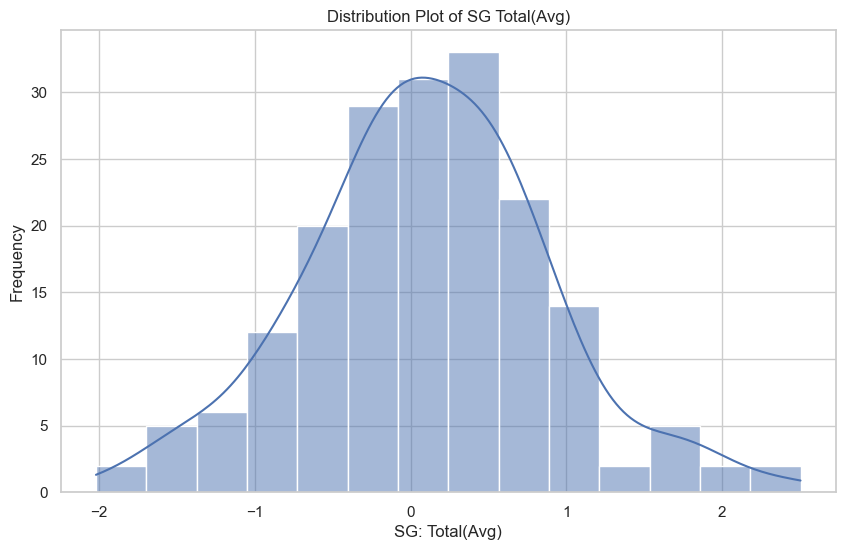

In [15]:
# Set style for the plots (optional)
sns.set(style="whitegrid")

# Create a distribution plot for SG Total(Avg)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

sns.histplot(data=df, x="SG: Total(Avg)", kde=True)  # Create a histogram with KDE

plt.title("Distribution Plot of SG Total(Avg)")
plt.xlabel("SG: Total(Avg)")
plt.ylabel("Frequency")
plt.savefig('SG_Total(Avg)_dist.png')
plt.show()

C:\Users\Illum\AppData\Local\Temp\ipykernel_34272\3849117360.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


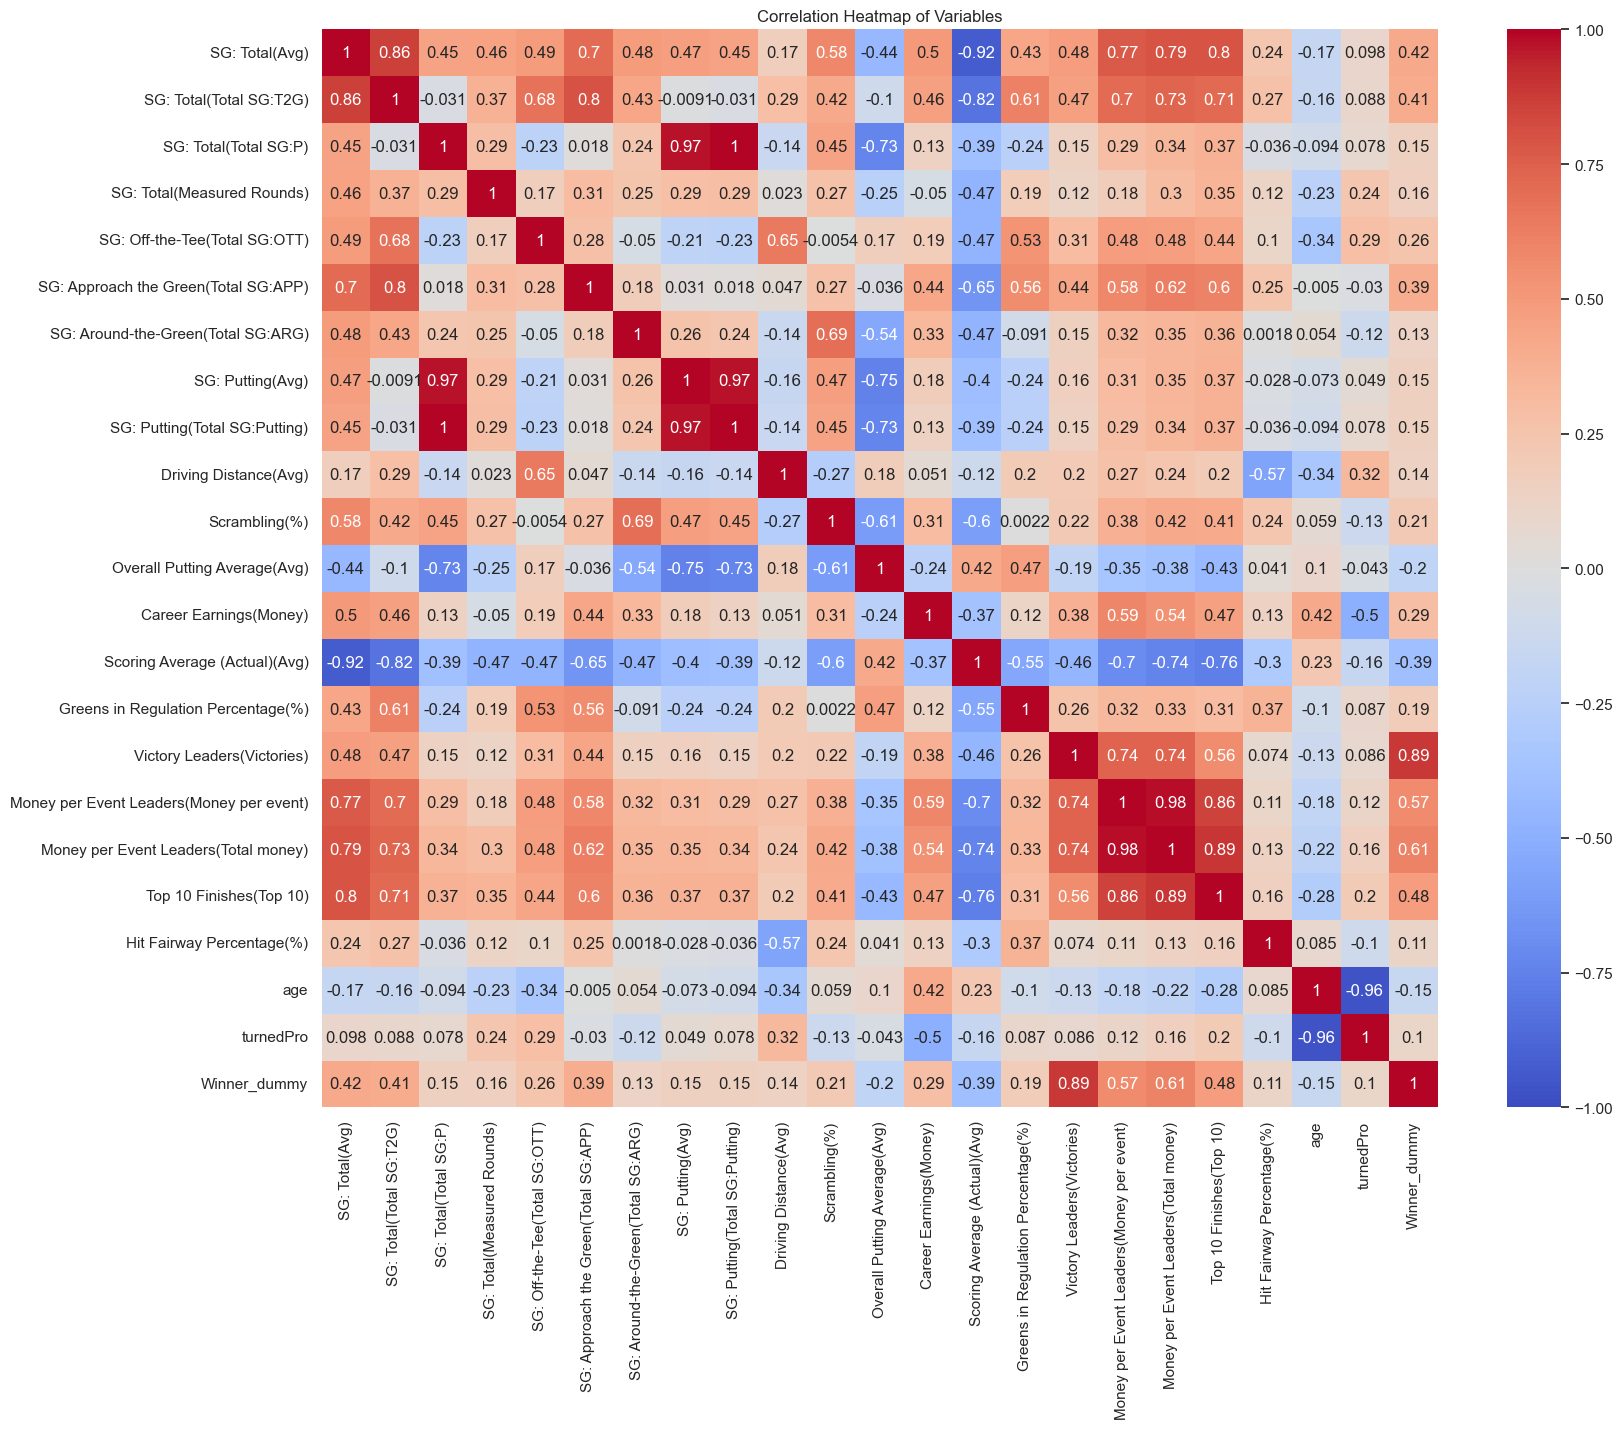

In [16]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the figure
plt.figure(figsize=(18, 14))  # Adjust the figure size as needed

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title("Correlation Heatmap of Variables")
plt.savefig('correlation_heatmap.png')
plt.show()

In [17]:
df.corr()['Victory Leaders(Victories)']

C:\Users\Illum\AppData\Local\Temp\ipykernel_34272\4206621012.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['Victory Leaders(Victories)']


SG: Total(Avg)                              0.477177
SG: Total(Total SG:T2G)                     0.466166
SG: Total(Total SG:P)                       0.147355
SG: Total(Measured Rounds)                  0.120470
SG: Off-the-Tee(Total SG:OTT)               0.307944
SG: Approach the Green(Total SG:APP)        0.442761
SG: Around-the-Green(Total SG:ARG)          0.151889
SG: Putting(Avg)                            0.159064
SG: Putting(Total SG:Putting)               0.147355
Driving Distance(Avg)                       0.204439
Scrambling(%)                               0.216876
Overall Putting Average(Avg)               -0.192258
Career Earnings(Money)                      0.378509
Scoring Average (Actual)(Avg)              -0.456147
Greens in Regulation Percentage(%)          0.261600
Victory Leaders(Victories)                  1.000000
Money per Event Leaders(Money per event)    0.737091
Money per Event Leaders(Total money)        0.741252
Top 10 Finishes(Top 10)                     0.

C:\Users\Illum\AppData\Local\Temp\ipykernel_34272\1579791429.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.catplot(


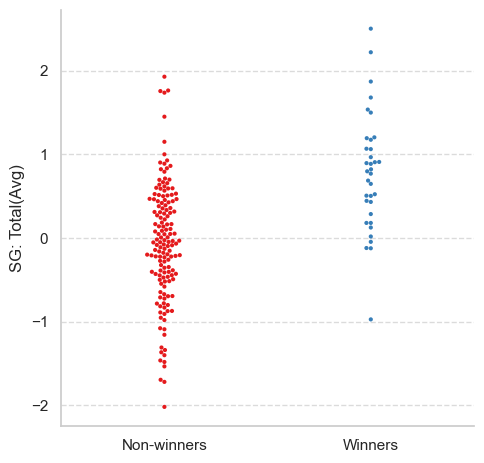

In [18]:
# Create the plot
ax = sns.catplot(
    x="Winner_dummy",
    y="SG: Total(Avg)",
    kind="swarm",
    data=df,
    size=3,
    palette="Set1"  # Use the custom colors
)

# Set labels and title
ax.set(xlabel='', ylabel='SG: Total(Avg)')

# Customize the aesthetics
sns.despine()  # Remove spines
plt.grid(True, axis="y", linestyle="--", alpha=0.7)  # Add horizontal grid lines
plt.xticks([0, 1], ["Non-winners", "Winners"])  # Customize x-axis labels
plt.savefig("SG_Total_avg_scatter.png", dpi=300)  # Save the plot
# Show the plot
plt.show()

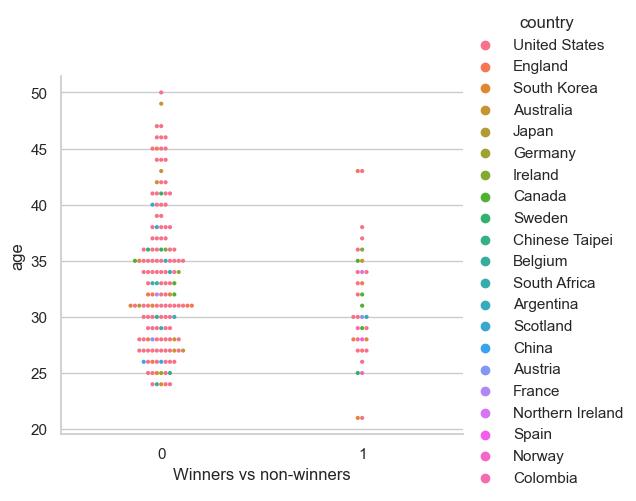

In [19]:
ax = sns.catplot(x="Winner_dummy", y="age", kind="swarm", hue="country", data=df, size=3)
ax.set(xlabel='Winners vs non-winners', ylabel='age');

In [20]:
# Count the number of players for each education
country_counts = df['education'].value_counts()

print(country_counts)

outside the US                       24
University of Georgia                 9
University of Nevada-Las Vegas        7
University of Texas                   7
Oklahoma State University             6
                                     ..
Brigham Young University              1
Missouri Western State University     1
University of South Carolina          1
East Tennessee State University       1
Temple University                     1
Name: education, Length: 78, dtype: int64


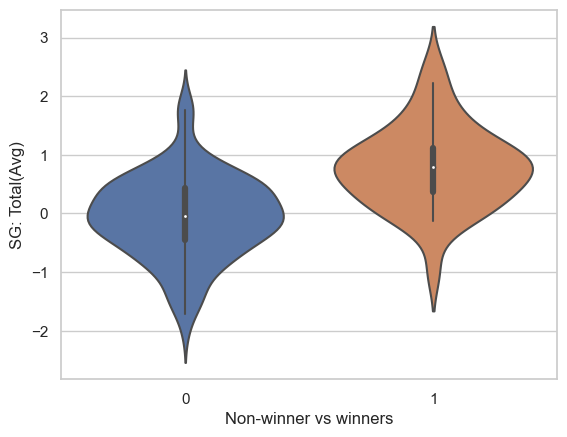

In [21]:
ax = sns.violinplot(x='Winner_dummy', y='SG: Total(Avg)', data=df)
ax.set(xlabel='Non-winner vs winners', ylabel='SG: Total(Avg)');

In [22]:
print(df['SG: Total(Avg)'].dtype)
print(df['Career Earnings(Money)'].dtype)

float64
float64


<Figure size 800x600 with 0 Axes>

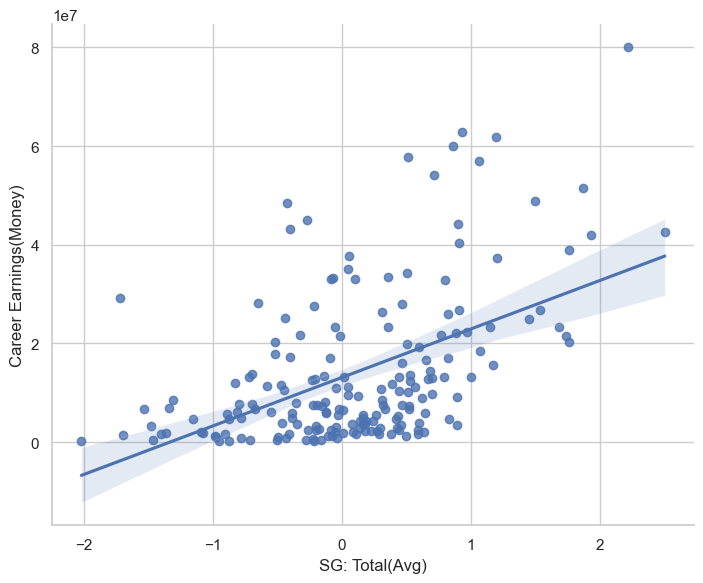

In [23]:
# Set the size of the plot
plt.figure(figsize=(8, 6))  # Adjust width and height as needed

# Create the lmplot with adjusted size
ax = sns.lmplot(x='SG: Total(Avg)', y='Career Earnings(Money)', data=df, height=6, aspect=1.2)

# Set labels for the plot
ax.set(xlabel='SG: Total(Avg)', ylabel='Career Earnings(Money)')

# Show the plot
plt.show()

c:\Users\Illum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


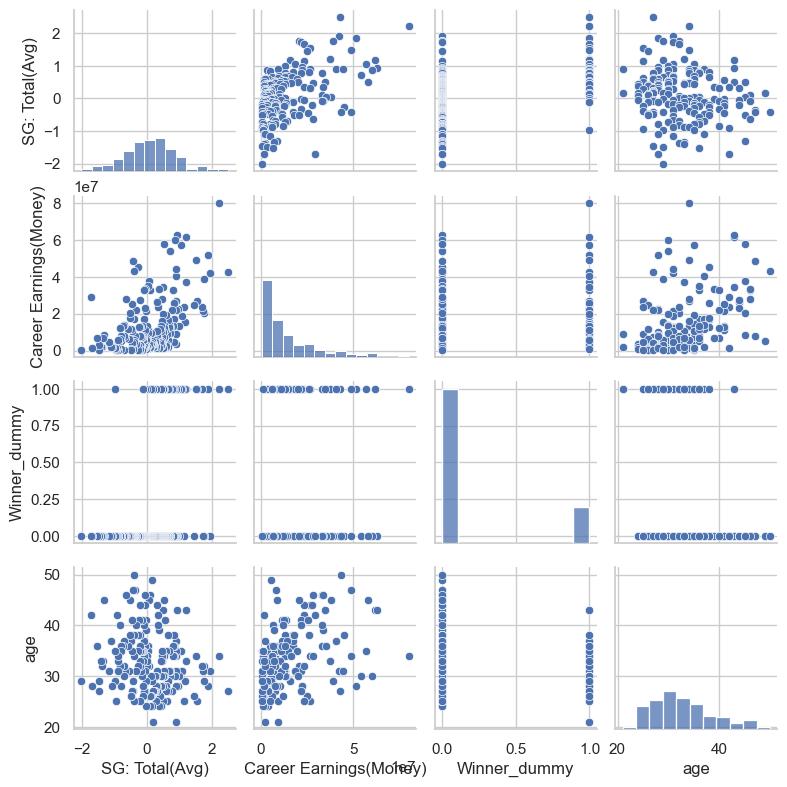

In [24]:
sns.pairplot(df, vars = ['SG: Total(Avg)', 'Career Earnings(Money)', 'Winner_dummy', 'age'] ,height=4, size=2); # make hist and scatter for all numeric variables

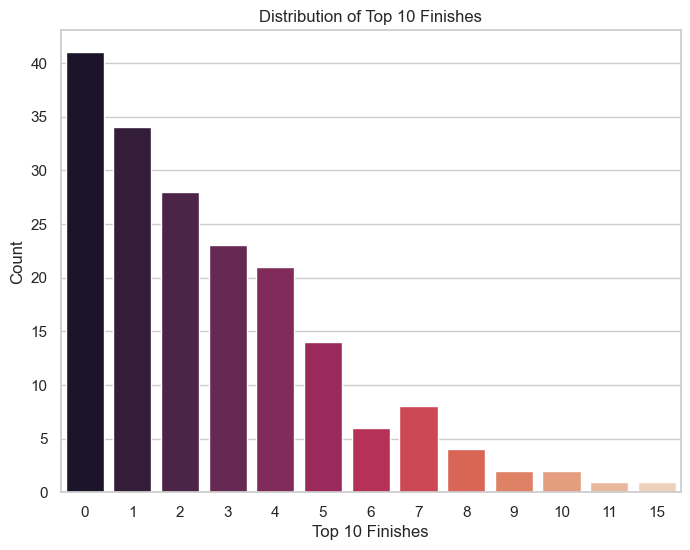

In [25]:
# Set the size of the plot
plt.figure(figsize=(8, 6))  # Adjust width and height as needed

# Create a bar plot for distribution of top ten finishes
ax = sns.countplot(x='Top 10 Finishes(Top 10)', data=df, palette='rocket')

# Set labels for the plot
ax.set(xlabel='Top 10 Finishes', ylabel='Count')
plt.title('Distribution of Top 10 Finishes')

# Show the plot
plt.show()

## 2. <a id='section 2'>Predicting winners with machine learning models: Classification </a>
<a href='#TOC'>Back to table of Contents</a>

The goal of this section is to use machine learning methods to predict if a player has won a tournament or not. For this purpose, we use a range of machine learning methods based on supervised learning to find the model with the best prediction accuracy. 

I.e. the goal is learning a prediction rule for labelled data. Out target is categorial; the player has either won or not won a tournament. 

### Imports 

In [26]:
# import packages and modules from SciKitLearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

### Prepare data for classification with partioning

In [27]:
#Features (X): Define the features that we will use to predict the target variable
X = df.drop(columns=['playerId','Winner_dummy', 'playerName', 'country', 'education', 'Victory Leaders(Victories)'])

# Target variable (y): 'Winner_dummy' column
y = df['Winner_dummy']

# Split the data into development and test data

# SPLIT INTO DEVELOPMENT (2/3) AND TEST DATA (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# SPLIT DEVELOPMENT INTO TRAIN (1/3) AND VALIDATION (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=42)

### Logistic regression classification

We start out testing a plain logistic regression model, which gives us an accuracy of 80.9% on the test data

In [28]:
# Estimate model on train data, evaluate on test data
clf = LogisticRegression(random_state=42) # Note: try default values

clf.fit(X_train, y_train) # Model training

y_hat_test = clf.predict(X_test) # Use model to predict test target
y_hat_train = clf.predict(X_train) # Predictions on training data

accuracy_test = (y_hat_test == y_test).mean() # Evaluate performance on test data
accuracy_train = (y_hat_train == y_train).mean() # Evaluate performance on training data

print(f"Accuracy on test data: {accuracy_test:.3f}")
print(f"Accuracy on training data: {accuracy_train:.3f}")

# Evaluate performance using classification report
report = classification_report(y_test, y_hat_test)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print("Classification Report:")
print(report)
print(f"ROC AUC score: {roc_auc:.3f}")

Accuracy on test data: 0.839
Accuracy on training data: 0.885
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        50
           1       0.67      0.33      0.44        12

    accuracy                           0.84        62
   macro avg       0.76      0.65      0.68        62
weighted avg       0.82      0.84      0.82        62

ROC AUC score: 0.833


Logistic Regression classifier, Lasso (L1) regularization and Ridge (L2) regularization

In [29]:
# Create a pipeline
pipe_lr = make_pipeline(
    PolynomialFeatures(),
    StandardScaler(),
    LogisticRegression(random_state=42, penalty = 'l1', C=2, solver='saga') # Change to penalty='l2' for Ridge regularization
)

# Fit the pipeline to the training data
pipe_lr.fit(X_train, y_train)

# Predict on the test data
y_pred_test = pipe_lr.predict(X_test)
y_pred_train = pipe_lr.predict(X_train)

# Evaluate the model
report = classification_report(y_test, y_pred_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)

roc_auc = roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:, 1]) # Use pipe_lr for prediction

print(f"Accuracy on test data: {accuracy_test:.3f}")
print(f"Accuracy on training data: {accuracy_train:.3f}")

print("Classification Report:")
print(report)

print(f"ROC AUC score: {roc_auc:.3f}")

Accuracy on test data: 0.855
Accuracy on training data: 0.918
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        50
           1       0.64      0.58      0.61        12

    accuracy                           0.85        62
   macro avg       0.77      0.75      0.76        62
weighted avg       0.85      0.85      0.85        62

ROC AUC score: 0.788


K-fold cross validation to optimize hyperparameter C

In [30]:
# Grid of lambdas
lambdas = np.linspace(0.001, 100, 60) 

# SETUPa
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))

# Outer loop: lambdas
accCV = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    accCV_ = []    
    for train_idx, val_idx in folds:
    
        # Reset indices for training and validation data
        X_train_fold, y_train_fold = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx]
        
        # Train model and compute accuracy on validation fold
        pipe_lrCV = make_pipeline(PolynomialFeatures(),
                                StandardScaler(),
                                LogisticRegression(random_state=42, penalty='l2', C=lambda_, solver='saga'))  # change to "penalty = 'l2' for l2 regularization"
        pipe_lrCV.fit(X_train_fold, y_train_fold)
        accCV_.append(accuracy_score(pipe_lrCV.predict(X_val), y_val))  
        
    # Store result    
    accCV.append(accCV_) 
    
# Convert to DataFrame
lambdaCV = pd.DataFrame(accCV, index=lambdas)

In [31]:
# CHOOSE OPTIMAL HYPERPARAMETERS (mean of accuracy across folds)
optimal_lambda = lambdaCV.mean(axis=1).nlargest(1)
print("Optimal lambda and optimal validation accuracy: ", optimal_lambda)

Optimal lambda and optimal validation accuracy:  1.695898    0.89359
dtype: float64


Training the model the with optimal hypeparameter

In [32]:
# CHOOSE OPTIMAL HYPERPARAMETERS (mean of accuracy across folds)
optimal_lambda = lambdaCV.mean(axis=1).nlargest(1)

# RETRAIN/RE-ESTIMATE MODEL USING OPTIMAL HYPERPARAMETERS AND COMPARE PERFORMANCE
pipe_lrCV = make_pipeline(PolynomialFeatures(), 
                             StandardScaler(),
                             LogisticRegression(C=optimal_lambda.index[0], random_state=42, penalty='l1', solver='saga'))

pipe_lrCV.fit(X_train,y_train) #fit optimal lambda to the training set 

models = {'LogReg': pipe_lr, 'LogRegCV': pipe_lrCV}
for name, model in models.items():
    score = accuracy_score(model.predict(X_test),y_test)
    print(name,round(score,3))

LogReg 0.855
LogRegCV 0.871


Learning curve

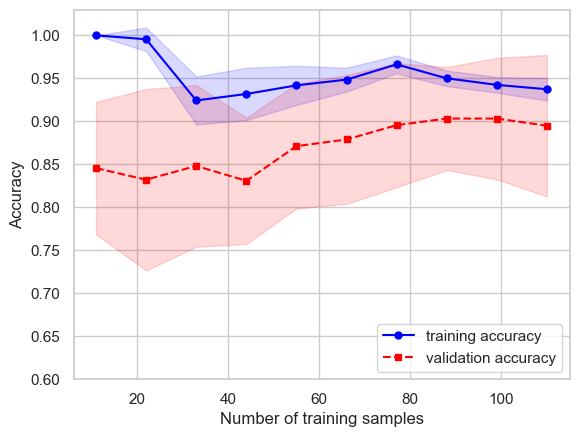

In [33]:
# Learning curve
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lrCV,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring='accuracy',                 
                   cv=10,
                   n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std= np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std= np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='red', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='red')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.60, 1.03])
plt.savefig('learning_curve.png', dpi=300)
plt.show()

Validation curve

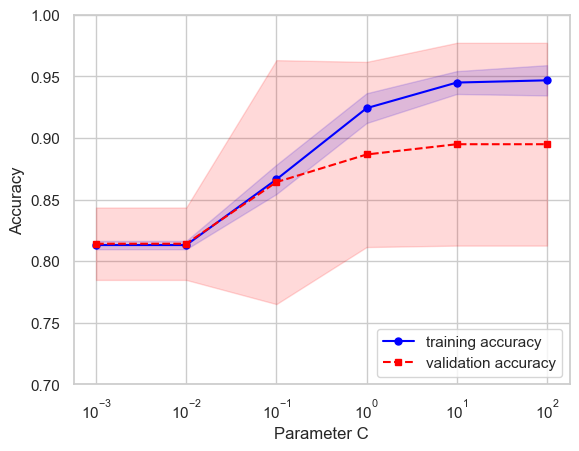

In [34]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                            estimator=pipe_lrCV,
                            X=X_dev,
                            y=y_dev,
                            param_name='logisticregression__C',
                            param_range=param_range,
                            cv=10)


train_mean = np.mean(train_scores, axis=1)
train_std= np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std= np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='red', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='red')

plt.grid(True)
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1.0])
plt.savefig('validation_curve.png', dpi=300)
plt.show()

Random forest model 

In [35]:
# Create a Random Forest Classifier with specified parameters
forest = RandomForestClassifier(
    criterion='gini',
    n_estimators=20,
    random_state=1,
    n_jobs=1)

# Fit the classifier to the training data
forest.fit(X_train, y_train)

# Predict on the test data
y_pred = forest.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.790


## 3. <a id='section_3'>Predicting earnings per event based on college background</a>
<a href='#TOC'>Back to table of Contents</a>

### Importing packages

In [36]:
# Import packages relevant for the this seciton 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Preparing dataframe for regression

Make dataframe and define features (X) and target (y)

In [37]:
# Create a new DataFrame
earning_df = df.copy()

# Remove rows with NaN values
earning_df.dropna(inplace=True)

# Y value for machine learning is the Money column
Y = earning_df['Money per Event Leaders(Money per event)']

# Removing the specified columns from the DataFrame
columns_to_drop = ['Winner_dummy', 'playerId', 'playerName', 'country', 'education', 'Victory Leaders(Victories)', 'Money per Event Leaders(Money per event)', 'Career Earnings(Money)', 'Money per Event Leaders(Total money)', 'Top 10 Finishes(Top 10)', 'SG: Total(Total SG:P)']
X = earning_df.drop(columns=columns_to_drop, axis=1)

### Setting up a linear regression function 

Making a function that partitions data intro training and test data and then fit the model 

In [38]:
def linear_reg(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 10)
    clf = LinearRegression().fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print('R-Squared on training set: {:.3f}'
          .format(clf.score(X_train, y_train)))
    print('R-Squared on test set {:.3f}'
          .format(clf.score(X_test, y_test)))
    
    print('linear model coeff (w):\n{}'
         .format(clf.coef_))
    print('linear model intercept (b): {:.3f}'
         .format(clf.intercept_))

### Defining linear regression with regularization

In [39]:
def linear_reg(X, Y, regularization='none', alpha=1.0):
    
    # Convert any non-numeric data to numeric, handling errors with 'coerce'
    X = X.apply(pd.to_numeric, errors='coerce')

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=10)
    
    if regularization == 'none':
        clf = LinearRegression().fit(X_train, y_train)
    elif regularization == 'lasso':
        clf = Lasso(alpha=alpha, max_iter=100000000).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    r2_train = clf.score(X_train, y_train)
    r2_test = clf.score(X_test, y_test)
    
    print('R-Squared on training set: {:.3f}'.format(r2_train))
    print('R-Squared on test set: {:.3f}'.format(r2_test))
    
    if regularization == 'none':
        print('linear model coeff (w):\n{}'.format(clf.coef_))
        print('linear model intercept (b): {:.3f}'.format(clf.intercept_))
    elif regularization == 'lasso':
        print('lasso model coeff (w):\n{}'.format(clf.coef_))
        print('lasso model intercept (b): {:.3f}'.format(clf.intercept_))

Now, you can use the modified X and Y in your linear_reg function as before

In [40]:
# Run regression
linear_reg(X, Y)  # Without regularization

R-Squared on training set: 0.685
R-Squared on test set: 0.638
linear model coeff (w):
[ 4.77095631e+04 -1.70166345e+03 -2.47786464e+03  3.49372301e+03
  3.40781841e+03  2.36961417e+03 -3.38264656e+04  1.15151971e+03
 -3.81855498e+01 -1.71121819e+03 -7.73952827e+05 -4.51148627e+04
  7.52286236e+02 -4.40651645e+02  3.53517508e+03  5.08253401e+03]
linear model intercept (b): -5581233.531


In [41]:
# Run regression 
linear_reg(X, Y, regularization='lasso')  # With Lasso regularization

R-Squared on training set: 0.685
R-Squared on test set: 0.638
lasso model coeff (w):
[ 4.73640930e+04 -1.70473550e+03 -2.47859998e+03  3.50101178e+03
  3.41422938e+03  2.37737045e+03 -3.30373108e+04  1.14755723e+03
 -4.15091962e+01 -1.70888306e+03 -7.58216795e+05 -4.57879067e+04
  5.98653925e+02 -4.36565389e+02  3.53214128e+03  5.07921739e+03]
lasso model intercept (b): -5541537.811


### Introducing polynomial features 

In [42]:
# Creating a Polynomial Feature to improve R-Squared
poly = PolynomialFeatures(2)
poly = poly.fit(X)
poly_earning = poly.transform(X)
print(poly_earning.shape)

# Creating a DataFrame with the polynomial features 
poly_earning = pd.DataFrame(poly_earning, columns = poly.get_feature_names(X.columns))

(185, 153)


Run regression

In [43]:
linear_reg(poly_earning, Y)

R-Squared on training set: 1.000
R-Squared on test set: -16.981
linear model coeff (w):
[ 1.32610055e-01 -1.76743382e+05 -1.79365860e+06  4.41491527e+05
 -1.93934857e+06  1.17891386e+06  1.08071226e+04 -2.90430720e+05
 -3.96664771e+06  1.19564104e+06 -6.80165683e+06  9.05198511e+03
  2.35802830e+05  9.06204549e+05 -8.30237524e+06 -4.49747429e+06
  3.94286251e+06 -1.74503162e+05  1.10499996e+05  1.01796469e+06
 -8.13600310e+04 -1.05870255e+05 -1.89052965e+05  4.59413639e+06
 -6.02876812e+05 -1.15471211e+05  4.02826755e+03  5.19183189e+05
 -1.54020123e+06 -3.65408259e+04 -2.44954392e+05  1.14095522e+05
  7.78167275e+04  2.51091697e+02 -2.42356828e+02 -1.09061451e+03
 -1.02801206e+03 -1.16412305e+03  2.62147403e+05  2.77199117e+03
 -4.33404462e+03 -1.88189278e+03 -1.22445429e+06  9.33250223e+04
  9.30818145e+03 -6.01445615e+03 -3.50422516e+03 -1.27036887e+03
  6.83680669e+01  1.70348922e+02  6.82114488e+02  5.18157412e+02
  4.59123598e+05  5.79281606e+02 -1.49044019e+03  1.90305696e+03
  

Polynomial regression with ridge regularizaiton 

In [44]:
def linear_reg_ridge(X, Y, al):
    X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                   random_state = 10)
    clf = Ridge(alpha = al).fit(X_train, y_train)

    print('(poly deg 2 + ridge) R-squared score (training): {:.3f}'
         .format(clf.score(X_train, y_train)))
    print('(poly deg 2 + ridge) R-squared score (test): {:.3f}'
         .format(clf.score(X_test, y_test)))
    
    print('(poly deg 2 + ridge) linear model coeff (w):\n{}'
         .format(clf.coef_))
    print('(poly deg 2 + ridge) linear model intercept (b): {:.3f}'
         .format(clf.intercept_))

In [45]:
linear_reg_ridge(poly_earning, Y, al = 1)

(poly deg 2 + ridge) R-squared score (training): 0.979
(poly deg 2 + ridge) R-squared score (test): 0.364
(poly deg 2 + ridge) linear model coeff (w):
[ 0.00000000e+00 -1.63485790e+01  7.15235444e+02 -1.31066837e+03
  2.10043964e+03 -3.91079088e+02 -9.12411709e+02 -3.68578873e+01
 -2.44127847e+03  1.31158690e+03 -2.91904207e+02 -1.14783510e+00
  1.05663596e+01  7.36165714e+01 -4.66622239e+02 -1.22780090e+03
  1.16583865e+03  9.89835192e+03 -5.31343556e+03  1.64212141e+03
  4.69963081e+03  1.05799480e+04  1.35589967e+04  3.22401980e+03
  7.20361563e+03 -1.17559293e+04 -4.06465671e+04 -1.83346145e+03
 -5.92086255e+03 -2.52556764e+04 -3.22168670e+04  1.15178376e+03
  4.83820450e+03 -1.86388235e+02 -3.21736169e+02  8.95391855e+02
  5.89629829e+02  4.11534913e+02  8.28439290e+02  1.57756062e+02
 -4.53409597e+01  2.43127520e+03 -2.90339411e+04  2.41969821e+04
  1.83845344e+03 -7.10497316e+01 -1.12450162e+03 -9.18277539e+02
 -7.77470821e+01  1.24019793e+02  3.29066099e+02  1.51018091e+02
 -4.

In [46]:
linear_reg_ridge(poly_earning, Y, al = 100)

(poly deg 2 + ridge) R-squared score (training): 0.951
(poly deg 2 + ridge) R-squared score (test): 0.548
(poly deg 2 + ridge) linear model coeff (w):
[ 0.00000000e+00  4.15696821e-01  9.74177814e+01  8.31669207e+00
  4.65767134e+01  4.46336494e+01 -5.97532978e+00 -8.46611456e-01
 -7.29249895e+01  1.13709497e+01 -1.36391419e+00 -2.42805078e-01
  1.51354748e-01  5.03841267e+00  2.78125653e+00 -1.68074069e+01
  1.58883785e+01  1.97166425e+02  9.20113702e+02  5.40795454e+01
  3.81222236e+02 -5.97563515e+02  3.05048151e+03  1.04053788e+02
  9.96974887e+02  2.28463324e+03 -9.30861925e+02 -4.40603650e+01
 -1.44007634e+02 -6.69103731e+02 -3.54313289e+03  2.11318385e+02
 -1.78225443e+02 -4.57953468e+02 -7.40657374e+01  8.47607998e+02
  9.05522496e+02  6.19593476e+02  1.85771073e+03 -9.10706889e+01
  4.22817178e+02  8.10593232e+02 -1.89794760e+03 -9.94431163e+02
 -4.08562024e+02  2.26139470e+02 -1.20117310e+02 -3.91153305e+01
 -5.30002991e+01 -4.69761224e+01  9.26559654e+01 -2.02753122e+01
 -9.

### Cross validation 

In [47]:
def cross_val(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 10)
    clf = Ridge(alpha=100).fit(X_train, y_train)
    scores = cross_val_score(clf, X, Y, cv=5)
    
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print(scores)

In [48]:
cross_val(poly_earning, Y)

Accuracy: -20.08 (+/- 55.76)
[  0.19104933  -2.22465047  -1.89953324 -23.3258917  -73.13830186]


### Fetching the regression output for use in the project 

In [49]:
def find_earning_with_names(X, Y, education):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=10)
    clf = Ridge(alpha=100).fit(X_train, y_train)
    y_pred = clf.predict(X)
    y_pred = pd.Series(y_pred)

    pred_data = pd.concat([X, y_pred], axis=1)
    pred_name = pd.concat([pred_data, df[['education', 'playerName']]], axis=1)

    selected_earnings = pred_name.loc[pred_name['education'] == education]
    return selected_earnings  # Assuming the column name for target variable is 'Y'

education_category = "outside the US"
mean_predicted_earning = find_earning_with_names(X=poly_earning, Y=Y, education=education_category)
print(f"Mean predicted earning for education '{education_category}': {mean_predicted_earning}")

Mean predicted earning for education 'outside the US':        1  SG: Total(Avg)  SG: Total(Total SG:T2G)  SG: Total(Measured Rounds)  \
1    1.0           2.220                  114.091                        54.0   
4    1.0           1.763                   72.593                        58.0   
6    1.0           1.737                   69.459                        62.0   
11   1.0           1.203                   90.822                        69.0   
12   1.0           1.193                   42.587                        54.0   
16   1.0           1.062                   37.786                        60.0   
23   1.0           0.895                   61.151                        68.0   
43   1.0           0.594                   69.889                        83.0   
52   1.0           0.508                   57.344                        72.0   
54   1.0           0.503                   33.832                        80.0   
69   1.0           0.354                   -5.662     

In [50]:
# Calculate the mean
mean_money_per_event = df[df['education'] == 'outside the US']['Money per Event Leaders(Money per event)'].mean()

print("Mean of actual Money per Event:", mean_money_per_event)

mean_predicted_earning = mean_predicted_earning[mean_predicted_earning['education'] == 'outside the US'][0.].mean()

print("Mean predicted earnings:", mean_predicted_earning)

Mean of actual Money per Event: 151324.16666666666
Mean predicted earnings: 168576.09659459814
